# Financial Inclusion in Africa Zindi Competition


Remember to read the competition details in the zindi platform, [Zindi Africa](https://zindi.africa)

In [1]:
# import important modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import preprocessing module
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


#import classifier algorithm here
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier

#oversampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter

import warnings

np.random.seed(123)
warnings.filterwarnings('ignore')
%matplotlib inline

## Load Dataset

In [2]:
# Import data
train_data = pd.read_csv('../data/Train.csv')

In [3]:
# print shape
print('train data shape :', train_data.shape)

train data shape : (23524, 13)


In [4]:
# Inspect train Data
train_data.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Explolatory Data Analysis 

This is the process of finding some insights from you dataset before create predictive models.

**Note:** This is important steps in your Data science workflow.

In [5]:
#show list of columns
list(train_data.columns)

['country',
 'year',
 'uniqueid',
 'bank_account',
 'location_type',
 'cellphone_access',
 'household_size',
 'age_of_respondent',
 'gender_of_respondent',
 'relationship_with_head',
 'marital_status',
 'education_level',
 'job_type']

In [6]:
## show Some information about the dataset
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB
None


In [7]:
# Check for missing values
print('missing values:', train_data.isnull().sum())

missing values: country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64


We don't have missing data in our dataset.

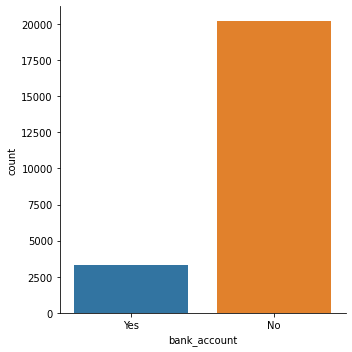

In [8]:
# Explore Target distribution

sns.catplot(x="bank_account", kind="count", data=train_data)

In [9]:
train_data['bank_account'].value_counts()

No     20212
Yes     3312
Name: bank_account, dtype: int64

The data shows that we have large number of **no** class than **yes** class  in our target variable 

In my previous article , I explained more about Exploratory data analysis with the financial Inclusion in Africa dataset.You can read and download the notebook [here](https://medium.com/analytics-vidhya/why-you-need-to-explore-your-data-how-you-can-start-13de6f29c8c1)

## Data Preprocessing 

In [10]:
# Convert target label to numerical Data
le = LabelEncoder()
train_data['bank_account'] = le.fit_transform(train_data['bank_account'])

#Separate training features from target
X_train = train_data.drop(['bank_account'], axis=1)
y_train = train_data['bank_account']

X_train.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


In [11]:
# our target 
y_train.head() 

0    1
1    0
2    1
3    0
4    0
Name: bank_account, dtype: int64

I have created a simple preprocessing function to handle 

- conversion of data types
- convert categorical features to numerical by one-hot encoding method and label encoding
- drop uniqueid variable 
- scaling our data into range of 0 and 1 

In [12]:
# function to preprocess our data from train models


def preprocessing_data(data):

    # drop uniquid column
    data = data.drop(["uniqueid"], axis=1)

    # Convert the following numerical labels from integer to float
    float_array = data[["household_size", "age_of_respondent",
                        "year"]].values.astype(float)

    # One Hot Encoding conversion
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

    data = enc.fit_transform(data)

    # scale our data into range of 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)

    return data,enc,scaler

In [13]:
# preprocess the train data 
processed_train_data,enc,scaler = preprocessing_data(X_train)

In [14]:
# the first train row 
processed_train_data[:1]

array([[1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1.]])

In [15]:
# shape of the processed train set
processed_train_data.shape 

(23524, 145)

In [16]:
# do undersampling

sm = RandomUnderSampler(random_state=42, sampling_strategy="majority")
X_res, y_res = sm.fit_resample(processed_train_data, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 3312, 1: 3312})


### Model Building and Experiment 

In [17]:
# create models
lg_model = LogisticRegression()
rf_model = RandomForestClassifier()
kn_model = KNeighborsClassifier()
et_model = ExtraTreesClassifier()
lightgbm_model = LGBMClassifier()

model_lists = [lg_model, rf_model, kn_model, et_model, lightgbm_model]

print(X_res.shape)
#fitting the models
for model in model_lists:
    print("Model name: {}".format(model))
    print("*" * 50)
    skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
    for train_index, test_index in skf.split(X_res, y_res):
        X_train, X_test = X_res[train_index], X_res[test_index]
        y_train, y_test = y_res[train_index], y_res[test_index]

        #train model
        model.fit(X_train, y_train)
        y_preds = model.predict(X_test)
        score = accuracy_score(y_preds, y_test)
        print("Accuracy score:{}".format(score))
    print("*" * 50)

(6624, 145)
Model name: LogisticRegression()
**************************************************
Accuracy score:0.7667924528301887
Accuracy score:0.7622641509433963
Accuracy score:0.7766037735849056
Accuracy score:0.7607547169811321
Accuracy score:0.7492447129909365
**************************************************
Model name: RandomForestClassifier()
**************************************************
Accuracy score:0.7554716981132076
Accuracy score:0.7358490566037735
Accuracy score:0.7426415094339622
Accuracy score:0.7464150943396226
Accuracy score:0.7537764350453172
**************************************************
Model name: KNeighborsClassifier()
**************************************************
Accuracy score:0.7230188679245283
Accuracy score:0.7071698113207547
Accuracy score:0.7335849056603774
Accuracy score:0.7320754716981132
Accuracy score:0.7333836858006042
**************************************************
Model name: ExtraTreesClassifier()
********************************

In [18]:
# save model 
# Note: I select lightgbm because of its performance and the size of the model is smaller compared to Extra-tree-classifier and random-forest-classifier (both of them has size more than 80MB)
import joblib

joblib.dump(lightgbm_model,"../model/lightgbm-financial-inclusion-model.pkl")

['../model/lightgbm-financial-inclusion-model.pkl']

In [19]:
# save encoders  
import joblib

joblib.dump(enc,"../preprocessing/one-hot-encoder.pkl")
joblib.dump(scaler,"../preprocessing/min-max-scaler.pkl")

['../preprocessing/min-max-scaler.pkl']

In [20]:
#install a package to change model into actual code
!pip install m2cgen

In [21]:
#load model to convert into python 
import joblib 

model = joblib.load("../model/random-forest-financial-inclusion-model.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../model/random-forest-financial-inclusion-model.pkl'

In [ ]:
type(model)

In [ ]:
#convert model into python code 
import m2cgen as m2c 
model_to_python = m2c.export_to_python(model)

In [ ]:
# show python code 
#open text file
text_file = open("model.txt", "w")

#write string to file
text_file.write(model_to_python)

#close file
text_file.close()